In [1]:
pip install netCDF4

In [2]:
import math
import h5py
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial

2.2.1+cu121


### Import Detrended PRECT and El Nino Data

Data detrended in "Detrend_BuildCNN.ipynb"

In [3]:
prect = pd.read_csv('Detrended_PRECT.csv')
prect.head()

,simulation,year,region,PRECT
0,1001.001,1940,Central,1.696816
1,1001.001,1940,North,-4.384861
2,1001.001,1940,South,2.359652
3,1001.001,1941,Central,7.414276
4,1001.001,1941,North,15.164542


In [4]:
nino = pd.read_csv('Nino_Data.csv')
nino = nino.groupby(['Sim', 'year']).sum()
nino.head()

Average_SST
Sim      year             
1001.001 1940   300.755161
         1941   300.476758
         1942   302.393693
         1943   298.560676
         1944   300.111834

In [5]:
from scipy.signal import detrend

nino_detrend = nino.copy()

for sim in np.array(nino.index.get_level_values("Sim").unique()):
    condition = nino.index.get_level_values('Sim') == sim
    subset_nino = nino.loc[condition]
    y = subset_nino.Average_SST.values
    dt = detrend(y)
    nino_detrend.loc[condition, 'Average_SST'] = dt

nino_detrend.head()

Average_SST
Sim      year             
1001.001 1940     0.327026
         1941     0.051076
         1942     1.970464
         1943    -1.860101
         1944    -0.306490

In [6]:
nino_detrend.query("Sim==1281.001")

Average_SST
Sim      year             
1281.001 1940     0.708717
         1941    -0.180582
         1942     0.059153
         1943     1.793774
         1944    -0.626771
...                    ...
         2009     2.060241
         2010     0.475908
         2011    -0.327451
         2012    -1.723460
         2013    -0.306483

[74 rows x 1 columns]

In [7]:
nino_detrend.reset_index()['Sim'].unique()

array([1001.001, 1011.001, 1021.002, 1031.002, 1041.003, 1051.003,
       1061.004, 1071.004, 1081.005, 1091.005, 1101.006, 1111.006,
       1121.007, 1131.007, 1141.008, 1151.008, 1161.009, 1171.009,
       1181.01 , 1191.01 , 1231.001, 1231.002, 1231.003, 1231.004,
       1231.005, 1231.006, 1231.007, 1231.008, 1231.009, 1231.01 ,
       1231.011, 1231.012, 1231.013, 1231.014, 1231.015, 1231.016,
       1231.017, 1231.018, 1231.019, 1231.02 , 1251.001, 1251.002,
       1251.003, 1251.004, 1251.005, 1251.006, 1251.007, 1251.008,
       1251.009, 1251.01 , 1251.011, 1251.012, 1251.013, 1251.014,
       1251.015, 1251.016, 1251.017, 1251.018, 1251.019, 1251.02 ,
       1281.001, 1281.002, 1281.003, 1281.004, 1281.005, 1281.006,
       1281.007, 1281.008, 1281.009, 1281.01 , 1281.011, 1281.012,
       1281.013, 1281.014, 1281.015, 1281.016, 1281.017, 1281.018,
       1281.019, 1281.02 , 1301.001, 1301.002, 1301.003, 1301.004,
       1301.005, 1301.006, 1301.007, 1301.008, 1301.009, 1301.

In [8]:
nino_detrend.to_csv('Detrended_Nino.csv', index=True)

### Sanity Plots

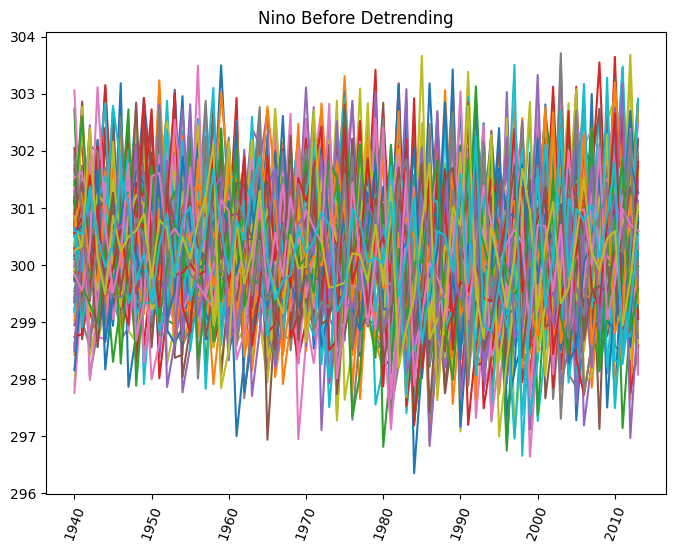

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

nino_filtered = nino.reset_index(inplace=False)

for simulation in nino_filtered['Sim'].unique():
    simulation_data = nino_filtered[nino_filtered['Sim'] == simulation]
    ax.plot(simulation_data['year'], simulation_data['Average_SST'], label=f'Simulation {simulation}')

ax.legend().remove()
plt.xticks(rotation=70)
plt.title('Nino Before Detrending')
plt.show()

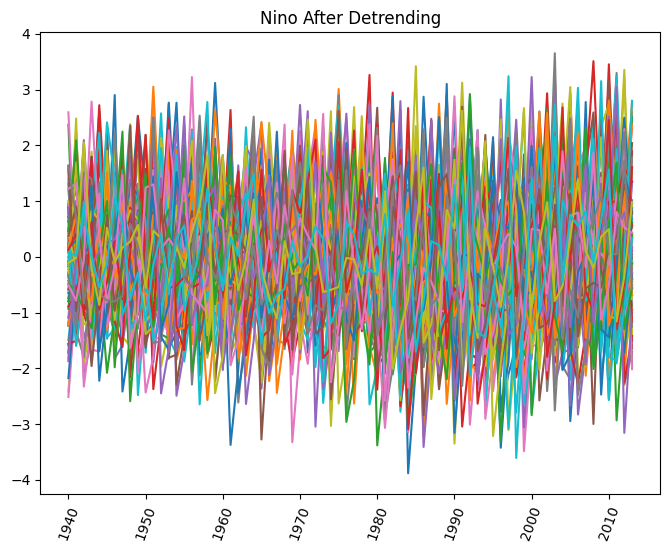

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

nino_filtered = nino_detrend.reset_index(inplace=False)

for simulation in nino_filtered['Sim'].unique():
    simulation_data = nino_filtered[nino_filtered['Sim'] == simulation]
    ax.plot(simulation_data['year'], simulation_data['Average_SST'], label=f'Simulation {simulation}')

ax.legend().remove()
plt.xticks(rotation=70)
plt.title('Nino After Detrending')
plt.show()

### Merge PRECT and El Nino SST data

In [11]:
nino_merge = nino_detrend.reset_index()
nino_merge = nino_merge.rename(columns={'Sim': 'simulation', 'Average_SST': 'SST'})
nino_merge.head()

,simulation,year,SST
0,1001.001,1940,0.327026
1,1001.001,1941,0.051076
2,1001.001,1942,1.970464
3,1001.001,1943,-1.860101
4,1001.001,1944,-0.306490


In [12]:
prect_merge = prect.reset_index()
prect_merge[["simulation"]] = prect_merge[["simulation"]].astype(float)
prect_merge[['year']] = prect_merge[['year']].astype(int)
prect_pivot = prect_merge.pivot_table(index=['year', 'simulation'], columns='region', values='PRECT')
prect_pivot = prect_pivot.rename(columns={'Central': 'PRECT_central', 'North': 'PRECT_north', 'South': 'PRECT_south'})
prect_pivot.reset_index(inplace=True)
prect_pivot.index.name = None
prect_pivot.head()

region,year,simulation,PRECT_central,PRECT_north,PRECT_south
0,1940,1001.001,1.696816,-4.384861,2.359652
1,1940,1011.001,2.410740,-0.784294,2.154759
2,1940,1021.002,7.004767,6.986447,4.734229
3,1940,1031.002,-2.724033,2.395675,-3.632084
4,1940,1041.003,-4.311492,-4.931686,-3.122911


In [13]:
final = pd.merge(nino_merge, prect_pivot, on = ['simulation', 'year'], validate = 'one_to_one', how = 'inner')
final.head()

,simulation,year,SST,PRECT_central,PRECT_north,PRECT_south
0,1001.001,1940,0.327026,1.696816,-4.384861,2.359652
1,1001.001,1941,0.051076,7.414276,15.164542,-0.276591
2,1001.001,1942,1.970464,1.005114,-0.246500,1.693045
3,1001.001,1943,-1.860101,-5.456921,-6.427475,-2.480597
4,1001.001,1944,-0.306490,7.008837,11.163982,1.050004


In [14]:
final.shape

(7400, 6)

### Train/Val/Test Split (same split as CNN)

In [15]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [16]:
simulations = final.simulation.unique()
print("Length of All Simulations:", len(simulations))
print(simulations)

Length of All Simulations: 100
[1001.001 1011.001 1021.002 1031.002 1041.003 1051.003 1061.004 1071.004
 1081.005 1091.005 1101.006 1111.006 1121.007 1131.007 1141.008 1151.008
 1161.009 1171.009 1181.01  1191.01  1231.001 1231.002 1231.003 1231.004
 1231.005 1231.006 1231.007 1231.008 1231.009 1231.01  1231.011 1231.012
 1231.013 1231.014 1231.015 1231.016 1231.017 1231.018 1231.019 1231.02
 1251.001 1251.002 1251.003 1251.004 1251.005 1251.006 1251.007 1251.008
 1251.009 1251.01  1251.011 1251.012 1251.013 1251.014 1251.015 1251.016
 1251.017 1251.018 1251.019 1251.02  1281.001 1281.002 1281.003 1281.004
 1281.005 1281.006 1281.007 1281.008 1281.009 1281.01  1281.011 1281.012
 1281.013 1281.014 1281.015 1281.016 1281.017 1281.018 1281.019 1281.02
 1301.001 1301.002 1301.003 1301.004 1301.005 1301.006 1301.007 1301.008
 1301.009 1301.01  1301.011 1301.012 1301.013 1301.014 1301.015 1301.016
 1301.017 1301.018 1301.019 1301.02 ]


In [17]:
# Perform the same train/test/val split
simulations_train_full, simulations_test, _, _ = train_test_split(simulations, simulations, test_size=0.1, random_state=49)
simulations_train, simulations_val, _, _ = train_test_split(simulations_train_full, simulations_train_full, test_size=0.1/0.9, random_state=49)

print("Length of Train Simulations:", len(simulations_train))
print("Length of Validation Simulations:", len(simulations_val))
print("Length of Test Simulations:", len(simulations_test))

Length of Train Simulations: 80
Length of Validation Simulations: 10
Length of Test Simulations: 10


In [18]:
#  Boolean masks for train/validation/test splits
train_mask = final['simulation'].isin(simulations_train)
val_mask = final['simulation'].isin(simulations_val)
test_mask = final['simulation'].isin(simulations_test)

final_train = final[train_mask]
final_val = final[val_mask]
final_test = final[test_mask]

### Train Model

In [19]:
print('Training Results:\n')
for region in ['PRECT_north', 'PRECT_central', 'PRECT_south']:
    # Train Model
    X = final_train['SST'].values.reshape(-1, 1)
    y = final_train[region].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)

    # Print Train Results
    print(f'Region {region}')
    print(f'R-Squared: {reg.score(X, y)}')
    print(f'Coefficient: {reg.coef_}')
    print(f'Intercept: {reg.intercept_}\n')

Training Results:

Region PRECT_north
R-Squared: 0.00378135737634111
Coefficient: [[0.37406413]]
Intercept: [-3.28846664e-14]

Region PRECT_central
R-Squared: 0.08508341203887337
Coefficient: [[1.27835729]]
Intercept: [-1.09617056e-13]

Region PRECT_south
R-Squared: 0.16757836052249797
Coefficient: [[1.02942339]]
Intercept: [-8.84814655e-14]



### Train/Test Model

Testing Results:

Region: PRECT_north
Coefficient: [[0.37406413]]
Intercept: [-3.28846664e-14]
R-Squared: 0.00045574672872239486
MSE: 44.7120038397214



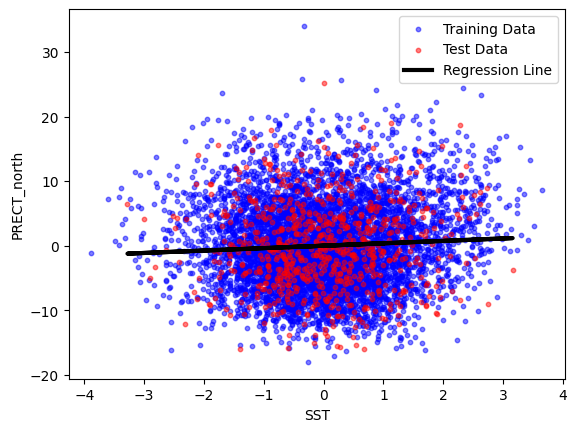

Region: PRECT_central
Coefficient: [[1.27835729]]
Intercept: [-1.09617056e-13]
R-Squared: 0.08411954237400288
MSE: 19.870800808963356



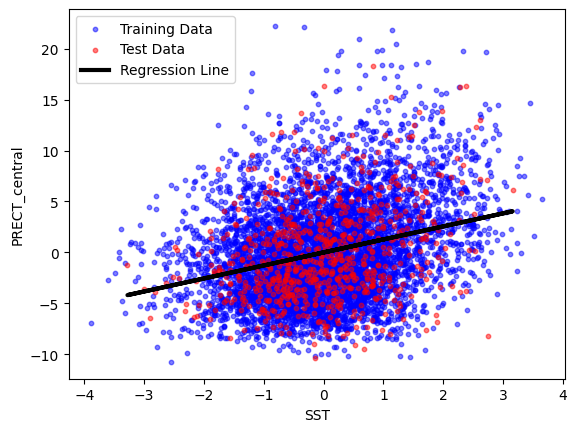

Region: PRECT_south
Coefficient: [[1.02942339]]
Intercept: [-8.84814655e-14]
R-Squared: 0.15468954505434473
MSE: 5.703927962804188



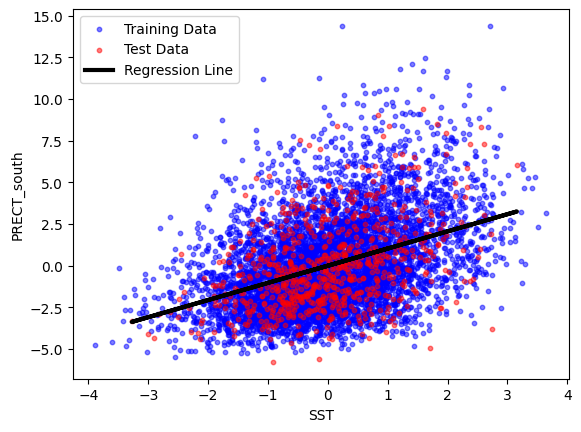

In [20]:
from sklearn.metrics import mean_squared_error

print('Testing Results:\n')
for region in ['PRECT_north', 'PRECT_central', 'PRECT_south']:
    # Train Model
    X_train = final_train['SST'].values.reshape(-1, 1)
    y_train = final_train[region].values.reshape(-1, 1)
    reg = LinearRegression().fit(X_train, y_train)

    # Test Model
    X_test = final_test['SST'].values.reshape(-1, 1)
    y_test = final_test[region].values.reshape(-1, 1)
    predictions = reg.predict(X_test)

    # Print Test Results
    print(f'Region: {region}')
    print(f'Coefficient: {reg.coef_}')
    print(f'Intercept: {reg.intercept_}')
    print(f'R-Squared: {reg.score(X_test, y_test)}')
    print(f'MSE: {mean_squared_error(y_test, predictions)}\n')

    # Plot Train, Test, Regression
    plt.scatter(X_train, y_train, color='blue', label='Training Data', alpha=0.5, s=10)
    plt.scatter(X_test, y_test, color='red', label='Test Data', alpha=0.5, s=10)
    plt.plot(X_test, predictions, color='black', linewidth=3, label='Regression Line')
    plt.xlabel('SST')
    plt.ylabel(region)
    plt.legend()
    plt.show()